## Mini Introdução OO

Uma grande parte das bibliotecas de hoje em dia, includindo o PyTorch, exploram conceitos de Orientação a Objetos (OO). Embora não tempos tempo de ensinar um curso inteiro de OO, seria pelo menos um semestre, podemos cobrir o essencial neste notebook. Caso queira uma única palavra para sumarizar: o essencial aqui é o conceito de **estado**!.

Existem dois termos importantes para entender OO:
1. Classes
2. Objetos

Classes definem um esqueleto do que será armazenado. Objetos definem uma instância da classe na memória. Abaixo temos uma classe simples chamadas de agregador. No momento, a mesma não faz nada!

In [ ]:
class Agregador(object):
    pass

Podemos instanciar nossas classes, ficando assim com dois objetos na memória:

In [ ]:
obj1 = Agregador()
obj2 = Agregador()

Cada instância, ou objeto, difere um do outro

In [ ]:
obj1 == obj2

Agora, vamos adicionar um **atributo**, um pouco de memória, na nossa classe. O mesmo guarda um valor simples. Se objetos são instâncias de classes, algum local tem guardar o estado desta instância. Em python, tal local é chamado de **self**. Todo objeto tem uma referência para seu estado, o self, que no fim das contas é uma referência para ele mesmo. 

O método `__init__(self)` é o **construtor** da classe, ou seja, quando um objeto é instanciado, esse método é chamado para definir o estado inicial do objeto. 

In [ ]:
class Agregador(object):
    def __init__(self):
        self._value = 0   # Toda instância agora guarda um inteiro simples!

In [ ]:
obj1 = Agregador()
obj2 = Agregador()

print(obj1._value)
print(obj2._value)

Dois objetos podem guardar um mesmo estado. Acima, os dois tem valor = 0. Ainda assim, são dois objetos diferentes, ocupam locais diferentes da memória do computador.

In [ ]:
hex(id(obj1))

In [ ]:
hex(id(obj2))

Por fim, objetos funcionam através de referências. A linha abaixo não cria um objeto novo, temos duas referências para um mesmo local da memória.

In [ ]:
obj3 = obj1
hex(id(obj3)) # note como aqui temos o mesmo endereco do obj1

In [ ]:
hex(id(obj1))

Como obj1 e obj3 são a mesma coisa, ao mudar um mudamos o outro.

In [ ]:
obj1._value = 9

In [ ]:
print(obj3._value)

Agora vamos tornar os nossos objetos um pouco mais inteligentes. Para tal, vamos adicionar um **método**, nome bonito para uma função, que altera o valor do atributo `_value`.

Embora é possível acessar o estado do objeto diretamente em python (vide acima), é uma boa prática alterar o mesmo usando apenas métodos. Por isso coloco um `_` antes do atributo, para indicar que não é bom acessar o mesmo diretamente.

In [ ]:
class Agregador(object):
    
    def __init__(self):
        self._value = 0 
    
    def adiciona(self, value):
        self._value += value
        
    def get_value(self):
        return self._value

In [ ]:
agg = Agregador()

Observe como temos uma chamada `get_value()`. 

In [ ]:
print(agg.get_value())

Ao adicionar alguma coisa, temos um novo estado!

In [ ]:
agg.adiciona(7)
print(agg.get_value())

Abaixo temos dois objetos diferentes com o mesmo estado. É isto!

In [ ]:
agg2 = Agregador()
agg2.adiciona(agg.get_value())

print(agg == agg2)
print(agg.get_value() == agg2.get_value())

No fim toda classe vai ser da forma:

```
class MinhaClasse(object):
    <código>
```

# Passo à Passo das Redes Neurais

A criação e treinamento de uma rede neural tem alguns passos que foram um *pipeline* completo.
Nesta aula, vamos ver cada passo para criar e treinar uma rede neural do zero usando PyTorch.

Num geral, para se utilizar uma rede neural, precisamos:

1. carregar e preparar os dados
2. definir a arquitetura/rede
3. definir a função de custo (loss)
4. definir o algoritmo de otimização
5. implementar os algoritmos de treino e validação

Antes de começar a analisar cada um desses passos, vamos realizar alguns imports e definir alguns hiperparamêtros.

## Imports e configurações iniciais

Antes de começar, vamos importar e definir algumas coisas. Para facilitar o entendimento e manutenção do código, os imports de pacotes, a configuração de **hiperparâmetros**, e a definição do hardware padrão utilizado serão sempre definidos no começo dos notebooks.

Nessa aula vamos trabalhar com dados reais, então **vamos precisar de GPU!** Então não se esqueça de mudar as configurações desse ambiente do colab. <br>
Sugiro rodar esse mesmo código sem GPU em outro momento, só para entenderem como a GPU facilitou o uso de redes neurais.


In [125]:
# Basic imports.
import os, sys, time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.backends import cudnn
cudnn.benchmark = True

from torch.utils.data import DataLoader
from torch.utils import data

from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

Nesta célula, além da definição do hardware padrão, estão também definidos os hiperparâmetros do nosso modelo. Mais à frente conversaremos um pouco melhor sobre eles.

In [127]:
# Setting predefined arguments.
args = {
    'num_epochs': 20,      # Number of epochs.
    'num_classes': 10,     # Number of classes.
    'lr': 1e-2,            # Learning rate.
    'weight_decay': 5e-4,  # L2 penalty.
    'num_workers': 3,      # Number of workers on data loader.
    'batch_size': 50,      # Mini-batch size.
}

# Setting device (CPU | CUDA)
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## 1. Carregamento de Dados

Para carregar os dados em PyTorch, precisamos definir o dataset e o dataloader.

### **Datasets**

### Dataset pré-implementado

O PyTorch possui dois pacotes que trazem datasets prontos para uso.

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

Como os nomes indicam, são datasets de textos (text) e imagens (vision), duas aplicações onde redes neurais são muito bem sucedidas.

Para aplicações com textos e outros tipos de séries temporais, o carregamento de dados possui nuances que dificultam o entendimento, portanto vamos concentrar no carregamento de imagens.

Para trabalhar com datasets do pacote torchvision, basta
* Importar o pacote
``` python 
from torchvision import datasets 
```
* Carregar o dataset do seu interesse (ex: MNIST)
``` python 
data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

> Note que o torch faz o carregamento das imagens no formato [Pillow](https://pillow.readthedocs.io/en/stable/). Portanto é necessário convertê-las para um tensor usando um [**Transformer**](https://pytorch.org/docs/stable/torchvision/transforms.html).

* Importar o pacote transforms
``` python 
from torchvision import transforms 
```
* preencher o parâmetro ```transform``` do dataset com a função que converte para tensor.
``` python 
transforms.ToTensor() 
```

Pronto! Quando seu dado for carregado, ele passará pela transformação indicada no parâmetro ```transform```, que nesse caso converte o dado para um tensor. Como veremos a seguir, é possível usar outros transformers.


In [109]:
train_set = datasets.MNIST('./', 
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))

Amostras de treino: 60000
Amostras de Teste:10000


Cada dataset possui uma implementação específica internamente no pytorch. Verifique o ```type``` da variável que recebeu os dados e veja que se refere a uma classe específica do dataset.

In [110]:
print(type(train_set))

torchvision.datasets.mnist.MNIST


Por se tratar de um conjunto de dados **supervisionado**, cada elemento do dataset é definido por uma tupla `(dado, rótulo)`. Para dados não supervisionados, cada elemento do dataset comporta apenas o dado.

In [111]:
print(type(train_set[0]))

print(type(train_set[0][0]))  # imagem
print(type(train_set[0][1]))  # classe

<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

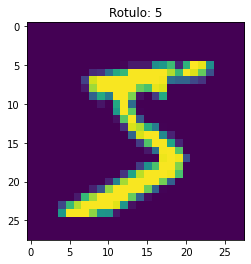

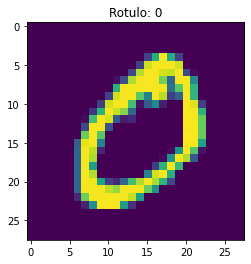

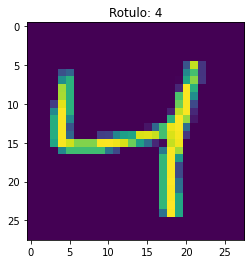

In [112]:
for i in range(3):
  dado, rotulo = train_set[i]
  
  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

Temos um total de 70 mil amostras, mas elas **ainda não estão carregadas na memória** (isso seria bastante custoso). A vantagem da classe ```Dataset``` do Pytorch é que as amostras só são carregadas quando necessário.

Para entender melhor, vamos experimentar a transformação a seguir
```python
transforms.RandomCrop(12)
```
Essa função realiza um recorte aleatório de ```12 x 12``` (pixels) na imagem. Ao carregar a mesma amostra múltiplas vezes, um novo recorte será feito. 

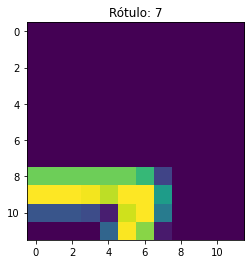

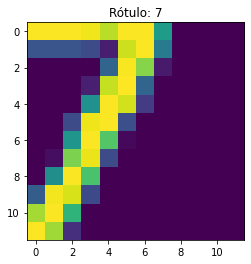

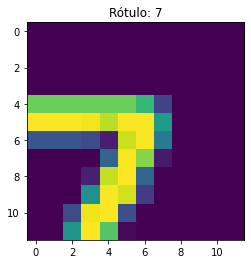

In [113]:
crop_set = datasets.MNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado)
  plt.title('Rótulo: '+ str(rotulo))

Em resumo, cada vez que indexamos um item do dataset, as seguintes operações são realizadas:
* Uma amostra é lida do arquivo e carregada como uma tupla ```(dado, rótulo)```
* As transformações são aplicadas 


### Dataset próprio

Na maioria das vezes, precisaremos carregar nosso próprio dado para processá-lo.
Nesses casos, teremos que implementar uma classe que estende a classe `dataset.Dataset`.
Essa nova classe tem três funções obrigatórios:

- `__init__`, construtor da classe e que inicialirá os parâmetros, incluindo a lista de dados que será processado. Por exemplo, se o dataset for composto de imagens, essa função precisa criar uma lista com o nome de todas as imagens a serem processadas.
- `__getitem__`, que, dado um índice, retorna um dado a ser processado. Esse função é responsável por carregar o dado e prepará-lo para processamento.
- `__len__`, que retorna a quantidade de itens no dataset a ser processado.

Segue abaixo um exemplo de como carregar um dataset de pontos de faces mas sobrescrevendo a classe `dataset.Dataset`.

In [155]:
# baixando o dataset e definindo algumas funcoes auxiliares

import subprocess
import zipfile

def download_dataset():
    if not os.path.isdir(os.path.join(os.getcwd(), 'faces_dataset')):
        os.makedirs(os.path.join(os.getcwd(), 'faces_dataset'))

    url = 'https://download.pytorch.org/tutorial/faces.zip'  # voce pode baixar o dataset usando esse link

    out_path = os.path.join(os.getcwd(), 'faces_dataset', 'faces.zip')

    cmd = ['curl', url, '-o', out_path]
    print('Downloading ', url)
    subprocess.call(cmd)

    with zipfile.ZipFile(out_path, "r") as zip_ref:
        zip_ref.extractall(os.path.join(os.getcwd(), 'faces_dataset'))

download_dataset()

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

Carregando o nosso dataset.

In [157]:
import pandas as pd

class FaceLandmarksDataset(data.Dataset):  # note que essa classe estende outra
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)  # criando lista de arquivos a serem lidos
        self.root_dir = root_dir  # endereço para as imagens
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)  # retorna total de imagens a serem processadas

    def __getitem__(self, idx):  # idx representa o indice da imagem a ser carregada
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)  # carrega as imagens de fato
        landmarks = self.landmarks_frame.iloc[idx, 1:]  # label
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Plotando alguns exemplos.

0 (324, 215, 3) (68, 2)


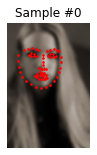

1 (500, 333, 3) (68, 2)


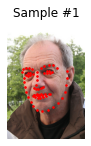

2 (250, 258, 3) (68, 2)


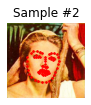

3 (434, 290, 3) (68, 2)


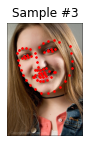

In [158]:
face_dataset = FaceLandmarksDataset(csv_file=os.path.join(os.getcwd(), 'faces_dataset', 'faces', 'face_landmarks.csv'),
                                    root_dir=os.path.join(os.getcwd(), 'faces_dataset', 'faces'))

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### **Dataloader**



O [Dataloader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) gerencia muito bem o carregamento de dados para o treinamento de redes neurais, trazendo as funções: 

* Separação dos dados em batches
* Embaralhando os dados
* Carregando batches em paralelo utilizando threads

O uso de threads no carregamento minimiza períodos ociosos de processamento, visto que a leitura de dados em arquivo é um grande gargalo de tempo.

As três funcionalidades que acabamos de conhecer são controladas pelos parâmetros da chamada do DataLoader.
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [114]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

torch.Size([50, 1, 28, 28]) torch.Size([50])


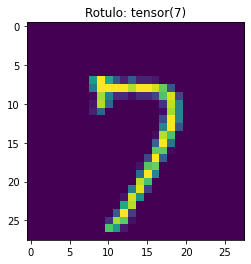

In [115]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0])
  plt.title('Rotulo: '+ str(rotulo[0]))
  break

Vale a pena visitar o [tutorial de carregamento de dados do PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) que introduz o uso das classes Dataset e Dataloader.

## 2. Definindo a Arquitetura

#### **Classe nn.Module**

O [nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) é a classe base para todos os módulos de redes neurais. 

A forma mais organizada de definir modelos em PyTorch é implementando uma classe. Para redes pequenas, como as que estamos aprendendo até o momento, sua importância pode não se destacar, mas modelos maiores e com funcionalidades mais complexas, são mais fáceis de implementar e realizar manutenções dessa forma.

Para implementar uma subclasse da ```nn.Module``` basta definir a subclasse da seguinte forma:
```python
class MinhaRede(nn.Module):
  # resto do código
```

Funções obrigatórias de subclasses da ```nn.Module```.
* ```__init()__```: definição da arquitetura da rede no estado interno da classe. Exemplo:
```python
# No __init__()
self.linear2 = nn.Linear(10,10)
```

* ```forward()```: Fluxo da entrada ao longo da rede e retorno da saída. Exemplo: 
```python
# No forward()
saida = self.linear2(entrada)
```

Existe também a função `backward` que pode ser implementada para definir o backprogation da camada explicitamente. Entretanto, não é necessário definir esse método para a maioria das redes neurais, já que o PyTorch implementa isso internamente.


**Implemente a seguir** um Multi-Layer Perceptron (MLP) intercalando camadas do tipo [`Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) com funções de ativação `ReLU`. 


Ainda falaremos mais sobre funções de ativação, mas para entender a importância das funções de ativação não-lineares após cada camada, visite a [demo de Stanford](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html). Ao remover as ativações não-lineares a rede se torna incapaz de aprender soluções não-lineares.<br>
A ativação pode ser definida de duas formas:
* Definida no `__init__()` [como uma camada](https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.ReLU) e aplicada no `forward()`
```python
# No __init__()
self.relu = nn.ReLU()
# No forward()
saida = self.relu(entrada)
```

* Apenas aplicada no `forward()` [como uma function](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu):
```python
saida = F.relu(entrada)
```

> **Lembrete**: Multi-Layer Perceptrons trabalham somente com dados unidimensionais (vetores). Sendo a imagem com dimensionalidade ```(1, 28, 28)```, precisamos linearizá-la antes de alimentar a rede (lembra da função `view`?). Isso implica que o a entrada da rede deve ser redimensionada para ```input_size = 28 x 28 x 1 = 784```

> **A dimensionalidade das camadas fica a seu critério.** São fixadas apenas a dimensionalidade da entrada (`784`) e da saída (`args['num_classes'] = 10` previamente definida).

In [128]:
class MinhaRede(nn.Module):
  
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    super(MinhaRede, self).__init__()
    
    # Definir a arquitetura
    self.hidden1 = nn.Linear(input_size, hidden1_size)
    self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
    self.output  = nn.Linear(hidden2_size, output_size)

  def forward(self, x):
    
    x = x.view(x.size(0), -1)
    h1 = F.relu(self.hidden1(x))
    h2 = F.relu(self.hidden2(h1))
    output = F.softmax(self.output(h2))
    
    return output

Instanciando a rede

In [129]:
input_size   = 28 * 28
hidden1_size = 1024
hidden2_size = 1024
out_size     = args['num_classes'] #classes

net = MinhaRede(input_size, hidden1_size, hidden1_size, out_size).to(args['device']) #cast na GPU 

## 3. Função de Perda e Otimizador

Por se tratar de um problema de classificação usaremos a função de custo [`CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).

Como ainda não vimos a fundo os otimizadores e suas vantagens, usaremos o já conhecido [`SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) da biblioteca `torch.optim`


In [130]:
# Define Loss
criterion = nn.CrossEntropyLoss().to(args['device'])

# Define Optimizer
optimizer = optim.SGD(params=net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

## 4. Fluxo de Treinamento e Validação

Agora implemente a seguir um fluxo completo de treinamento. Já fizemos isso antes, mas apenas relembrando o passo a passo:

* Iterar nas épocas (Número de épocas definido em `args['num_epochs']`)
* Iterar nos batches (*loader* `train_loader` pré definido que retornam uma tupla `(dado, rótulo)`)
* Cast dos dados no dispositivo de hardware (Dispositivo definido em `args['device']`)
* Forward do batch na rede 
* Cálculo da loss (`criterion` previamente definido)
* Cálculo do gradiente a partir da loss (autograd torch)
* Atualização dos pesos (`optimizer.step()`)

Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito de forma correta), ao final de cada época podemos imprimir a média e o desvio padrão das perdas de cada iteração.

Além disso, podemos usar a biblioteca [`metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) para calcular a acurácia do modelo.

In [131]:
preds_list = []
labels_list = []

for epoch in range(args['num_epochs']):
  start = time.time()

  epoch_loss = []
  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado   = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    optimizer.zero_grad()

    # Forward 
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Predições
    preds = pred.data.max(dim=1)[1].cpu().numpy()
    preds_list.append(preds)
    labels_list.append(rotulo.cpu().numpy())

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
                                 np.asarray(preds_list).ravel())

  end = time.time()

  print("Epoca %d, Loss: %.4f +\- %.4f, Acc: %.2f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoca 0, Loss: 2.2985 +\- 0.0030, Acc: 32.83, Tempo: 10.38
Epoca 1, Loss: 2.2739 +\- 0.0197, Acc: 27.57, Tempo: 10.38
Epoca 2, Loss: 2.1646 +\- 0.0657, Acc: 32.73, Tempo: 10.41
Epoca 3, Loss: 1.9307 +\- 0.0779, Acc: 39.47, Tempo: 10.38
Epoca 4, Loss: 1.7724 +\- 0.0561, Acc: 46.81, Tempo: 10.47
Epoca 5, Loss: 1.7014 +\- 0.0462, Acc: 52.50, Tempo: 10.07
Epoca 6, Loss: 1.6732 +\- 0.0468, Acc: 56.70, Tempo: 10.25
Epoca 7, Loss: 1.6588 +\- 0.0498, Acc: 59.94, Tempo: 10.20
Epoca 8, Loss: 1.6497 +\- 0.0493, Acc: 62.50, Tempo: 10.27
Epoca 9, Loss: 1.6435 +\- 0.0484, Acc: 64.59, Tempo: 10.10
Epoca 10, Loss: 1.6387 +\- 0.0473, Acc: 66.32, Tempo: 10.17
Epoca 11, Loss: 1.6350 +\- 0.0475, Acc: 67.79, Tempo: 10.19
Epoca 12, Loss: 1.6320 +\- 0.0473, Acc: 69.04, Tempo: 10.22
Epoca 13, Loss: 1.6294 +\- 0.0468, Acc: 70.13, Tempo: 10.35
Epoca 14, Loss: 1.6273 +\- 0.0473, Acc: 71.08, Tempo: 10.17
Epoca 15, Loss: 1.6255 +\- 0.0464, Acc: 71.92, Tempo: 10.28
Epoca 16, Loss: 1.6239 +\- 0.0471, Acc: 72.67, Tem

Agora implemente a seguir um fluxo completo de validação. O passo a passo nesse caso é:

* Iterar nos batches (*loader* `test_loader` pré definido que retornam uma tupla `(dado, rótulo)`)
* Cast dos dados no dispositivo de hardware (Dispositivo definido em `args['device']`)
* Forward do batch na rede 
* Cálculo das métricas

In [132]:
preds_list = []
labels_list = []

for batch in test_loader:
  
  dado, rotulo = batch

  # Cast na GPU
  dado   = dado.to(args['device'])
  rotulo = rotulo.to(args['device'])

  # Forward 
  pred = net(dado)

  # Predições
  preds = pred.data.max(dim=1)[1].cpu().numpy()
  preds_list.append(preds)
  labels_list.append(rotulo.cpu().numpy())


acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
                                np.asarray(preds_list).ravel())

print("Acc: %.2f" % (acc*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Acc: 85.44
